<a href="https://colab.research.google.com/github/LAMECH9/LAMECH9/blob/main/Geo_Spatial_Analysis_and_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importing the required libraries and setting up the figure parameters
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
import lightgbm as lgb
from sklearn.model_selection import KFold
from matplotlib import rcParams
dark_colors = ["#99D699", "#B2B2B2",
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]
rcParams['figure.figsize'] = (12, 9)
rcParams['figure.dpi'] = 150
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = "white"
rcParams['axes.titlesize'] = 20
rcParams['axes.labelsize'] = 17.5
rcParams['xtick.labelsize'] = 15
rcParams['ytick.labelsize'] = 15
rcParams['legend.fontsize'] = 17.5
rcParams['patch.edgecolor'] = 'none'
rcParams['grid.color']="white"
rcParams['grid.linestyle']="-"
rcParams['grid.linewidth'] = 1
rcParams['grid.alpha']=1
rcParams['text.color'] = "444444"
rcParams['axes.labelcolor'] = "444444"
rcParams['ytick.color'] = "444444"
rcParams['xtick.color'] = "444444"

In [ ]:
trips_df = pd.read_csv('/content/trip.csv')
stations_df = pd.read_csv('/content/station.csv')
weather_df = pd.read_csv('/content/weather.csv')

In [ ]:
stations_df.head()

,id,name,lat,long,dock_count,city,installation_date
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013


In [ ]:
stations_df.dtypes

,0
id,int64
name,object
lat,float64
long,float64
dock_count,int64
city,object
installation_date,object


In [ ]:
heatmap = folium.Map(
    location=[stations_df["lat"].median(), stations_df["long"].median()],
    zoom_start=10,
    tiles='Stamen Toner',
    attr='&copy; <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, &copy; <a href="http://maps.stamen.com/">Stamen Design</a>'
)

In [ ]:
stations_df["lat"] = stations_df["lat"].apply(lambda x:str(x))
stations_df["long"] = stations_df["long"].apply(lambda x:str(x))

In [ ]:
stations_df.head()

,id,name,lat,long,dock_count,city,installation_date
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013
3,5,Adobe on Almaden,37.331415,-121.8932,19,San Jose,8/5/2013
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013


In [ ]:
from folium.plugins import HeatMap
stations_loc = [[float(stations_df.lat.values[i]),float(stations_df.long.values[i])] for i in range(len(stations_df))]
heatmap.add_child(HeatMap(stations_loc,radius=10))
for index,row in stations_df.iterrows():
    folium.Marker([float(row['lat']),float(row['long'])],popup=row['name']).add_to(heatmap)

In [ ]:
heatmap

In [ ]:
trips_df.head()

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code
0,4576,63,8/29/2013 14:13,South Van Ness at Market,66,8/29/2013 14:14,South Van Ness at Market,66,520,Subscriber,94127
1,4607,70,8/29/2013 14:42,San Jose City Hall,10,8/29/2013 14:43,San Jose City Hall,10,661,Subscriber,95138
2,4130,71,8/29/2013 10:16,Mountain View City Hall,27,8/29/2013 10:17,Mountain View City Hall,27,48,Subscriber,97214
3,4251,77,8/29/2013 11:29,San Jose City Hall,10,8/29/2013 11:30,San Jose City Hall,10,26,Subscriber,95060
4,4299,83,8/29/2013 12:02,South Van Ness at Market,66,8/29/2013 12:04,Market at 10th,67,319,Subscriber,94103


In [ ]:
trips_df['start_date'] = pd.to_datetime(trips_df['start_date'])
trips_df['end_date'] = pd.to_datetime(trips_df['end_date'])

In [ ]:
start_station_info = stations_df[["id","lat","long"]]
start_station_info.columns = ["start_station_id","start_lat","start_long"]
end_station_info = stations_df[["id","lat","long"]]
end_station_info.columns = ["end_station_id","end_lat","end_long"]
trips_df = trips_df.merge(start_station_info,on="start_station_id")
trips_df = trips_df.merge(end_station_info,on="end_station_id")

In [ ]:
trips_df.head()

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code,start_lat,start_long,end_lat,end_long
0,4576,63,2013-08-29 14:13:00,South Van Ness at Market,66,2013-08-29 14:14:00,South Van Ness at Market,66,520,Subscriber,94127,37.774814,-122.418954,37.774814,-122.418954
1,4607,70,2013-08-29 14:42:00,San Jose City Hall,10,2013-08-29 14:43:00,San Jose City Hall,10,661,Subscriber,95138,37.337391,-121.886995,37.337391,-121.886995
2,4130,71,2013-08-29 10:16:00,Mountain View City Hall,27,2013-08-29 10:17:00,Mountain View City Hall,27,48,Subscriber,97214,37.389218,-122.081896,37.389218,-122.081896
3,4251,77,2013-08-29 11:29:00,San Jose City Hall,10,2013-08-29 11:30:00,San Jose City Hall,10,26,Subscriber,95060,37.337391,-121.886995,37.337391,-121.886995
4,4299,83,2013-08-29 12:02:00,South Van Ness at Market,66,2013-08-29 12:04:00,Market at 10th,67,319,Subscriber,94103,37.774814,-122.418954,37.776619,-122.417385


In [ ]:
plot_dict = dict()
for index,row in trips_df.iterrows():
    start_lat = row['start_lat']
    start_long = row['start_long']
    end_lat = row['end_lat']
    end_long = row['end_long']
    key = str(start_lat)+'_'+str(start_long)+'_'+str(end_lat)+'_'+str(end_long)
    if key in plot_dict:
        plot_dict[key] += 1
    else:
        plot_dict[key] = 1

In [ ]:
start_lat = []
start_long = []
end_lat = []
end_long = []
nb_trips = []
for key,value in plot_dict.items():
    start_lat.append(float(key.split('_')[0]))
    start_long.append(float(key.split('_')[1]))
    end_lat.append(float(key.split('_')[2]))
    end_long.append(float(key.split('_')[3]))
    nb_trips.append(int(value))

In [ ]:
temp_df = pd.DataFrame({"start_lat":start_lat,"start_long":start_long,"end_lat":end_lat,"end_long":end_long,"nb_trips":nb_trips})

In [ ]:
temp_df.dtypes

,0
start_lat,float64
start_long,float64
end_lat,float64
end_long,float64
nb_trips,int64


<Axes: >

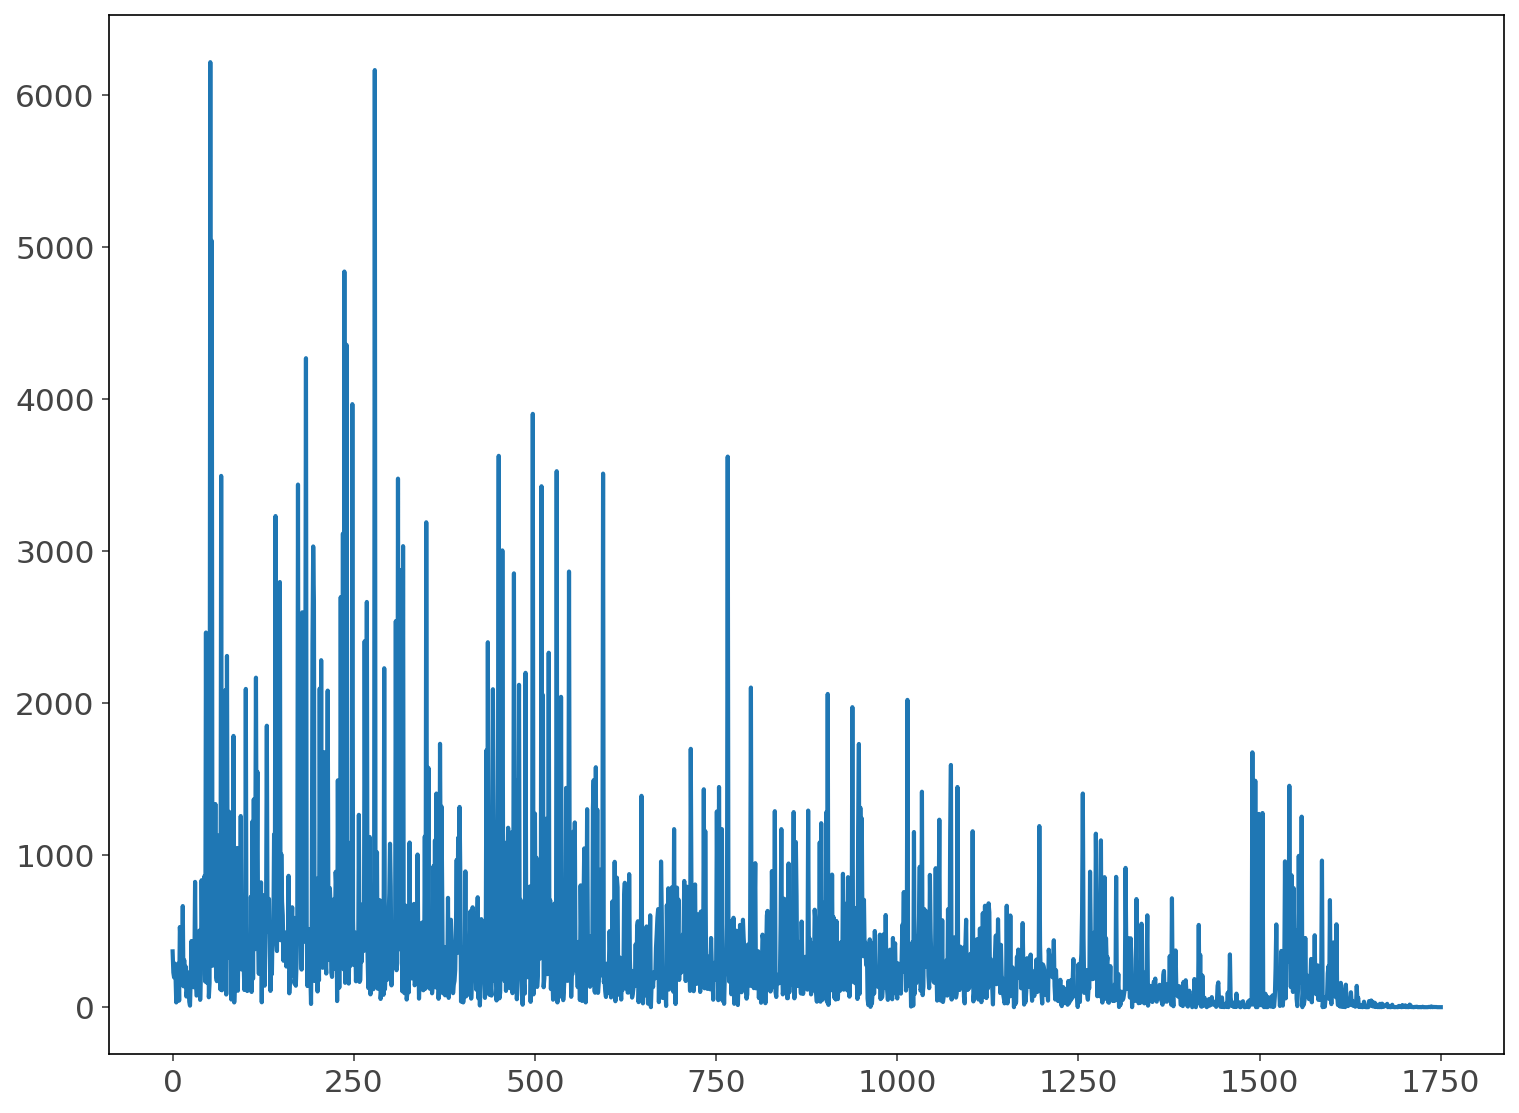

In [ ]:
temp_df.nb_trips.plot()

In [ ]:
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1751 entries, 0 to 1750
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   start_lat   1751 non-null   float64
 1   start_long  1751 non-null   float64
 2   end_lat     1751 non-null   float64
 3   end_long    1751 non-null   float64
 4   nb_trips    1751 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 68.5 KB


In [ ]:
temp_df.head()

,start_lat,start_long,end_lat,end_long,nb_trips
0,37.774814,-122.418954,37.774814,-122.418954,368
1,37.337391,-121.886995,37.337391,-121.886995,229
2,37.389218,-122.081896,37.389218,-122.081896,197
3,37.774814,-122.418954,37.776619,-122.417385,288
4,37.781332,-122.418603,37.781332,-122.418603,210


In [ ]:
ave_lat = (temp_df.start_lat.median()+temp_df.end_lat.median())/2
ave_lon = (temp_df.start_long.median()+temp_df.end_long.median())/2
directions_map = folium.Map(location=[ave_lat, ave_lon], zoom_start=15)

In [ ]:
for index,row in temp_df.iterrows():
    points = []
    points.append(tuple([row['start_lat'],row['start_long']]))
    points.append(tuple([row['end_lat'],row['end_long']]))
    folium.PolyLine(points,color='red',weight=row['nb_trips']/1000).add_to(directions_map)

In [ ]:
for index,row in stations_df.iterrows():
    folium.Marker([float(row['lat']),float(row['long'])],popup=row['name']).add_to(directions_map)

In [ ]:
directions_map

ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'labelfontfamily', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

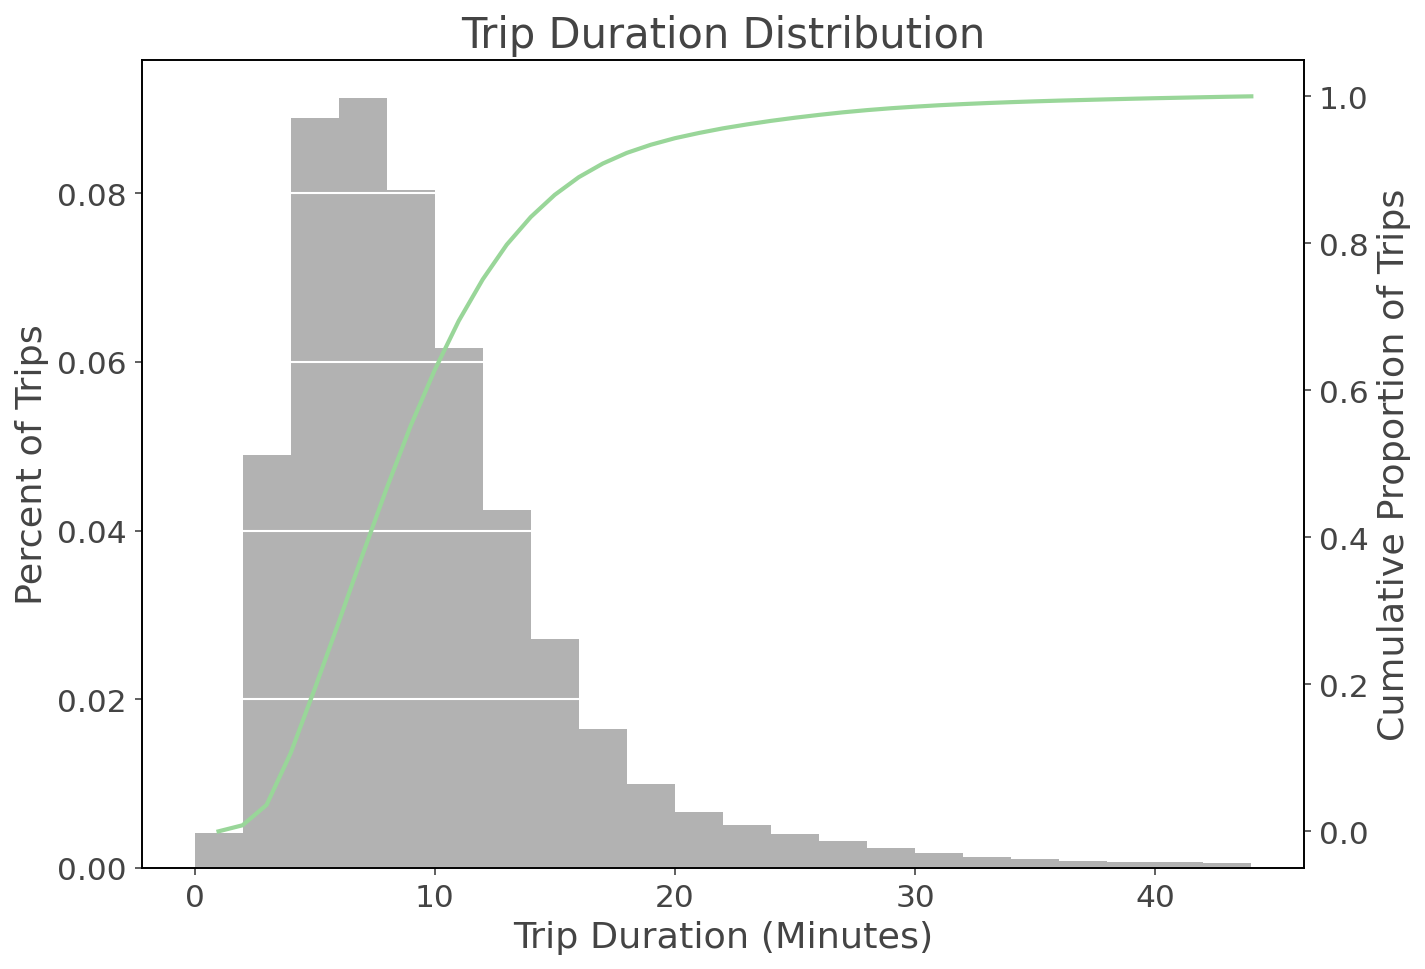

<Figure size 2250x1800 with 0 Axes>

In [ ]:
fig, ax1 = plt.subplots(figsize = (10,7))
ax1.grid(zorder=1)
ax1.xaxis.grid(False)
trip_dur = trips_df['duration'].values/60
# Replace 'normed=True' with 'density=True'
plt.hist(trip_dur, bins = range(0,45,2),density=True,zorder=0,color=dark_colors[1])
plt.xlabel('Trip Duration (Minutes)')
plt.ylabel('Percent of Trips')
plt.title('Trip Duration Distribution')
plt.figure(figsize=(15,12))
# Replace 'normed=True' with 'density=True'
hist, bin_edges = np.histogram(trip_dur, range(0,45,1), density=True)
cum_trip_dur = np.cumsum(hist)
ax2 = ax1.twinx()
ax2.plot(range(1,45,1),cum_trip_dur,c=dark_colors[0])
ax2.set_ylabel('Cumulative Proportion of Trips')
ax2.grid(b=False)

In [ ]:
trips_df.head()

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code,start_lat,start_long,end_lat,end_long
0,4576,63,2013-08-29 14:13:00,South Van Ness at Market,66,2013-08-29 14:14:00,South Van Ness at Market,66,520,Subscriber,94127,37.774814,-122.418954,37.774814,-122.418954
1,4607,70,2013-08-29 14:42:00,San Jose City Hall,10,2013-08-29 14:43:00,San Jose City Hall,10,661,Subscriber,95138,37.337391,-121.886995,37.337391,-121.886995
2,4130,71,2013-08-29 10:16:00,Mountain View City Hall,27,2013-08-29 10:17:00,Mountain View City Hall,27,48,Subscriber,97214,37.389218,-122.081896,37.389218,-122.081896
3,4251,77,2013-08-29 11:29:00,San Jose City Hall,10,2013-08-29 11:30:00,San Jose City Hall,10,26,Subscriber,95060,37.337391,-121.886995,37.337391,-121.886995
4,4299,83,2013-08-29 12:02:00,South Van Ness at Market,66,2013-08-29 12:04:00,Market at 10th,67,319,Subscriber,94103,37.774814,-122.418954,37.776619,-122.417385


In [ ]:
trips_df['week']=trips_df.start_date.dt.dayofweek
trips_df['start_hour'] = trips_df.start_date.dt.hour
trips_df['start_day'] = trips_df.start_date.dt.day
trips_df['end_hour'] = trips_df.end_date.dt.hour
trips_df['end_day'] = trips_df.end_date.dt.day

Text(0.5, 1.0, 'Trip Duration Distribution Over Time of Day (Week Days)')

<Figure size 2250x1800 with 0 Axes>

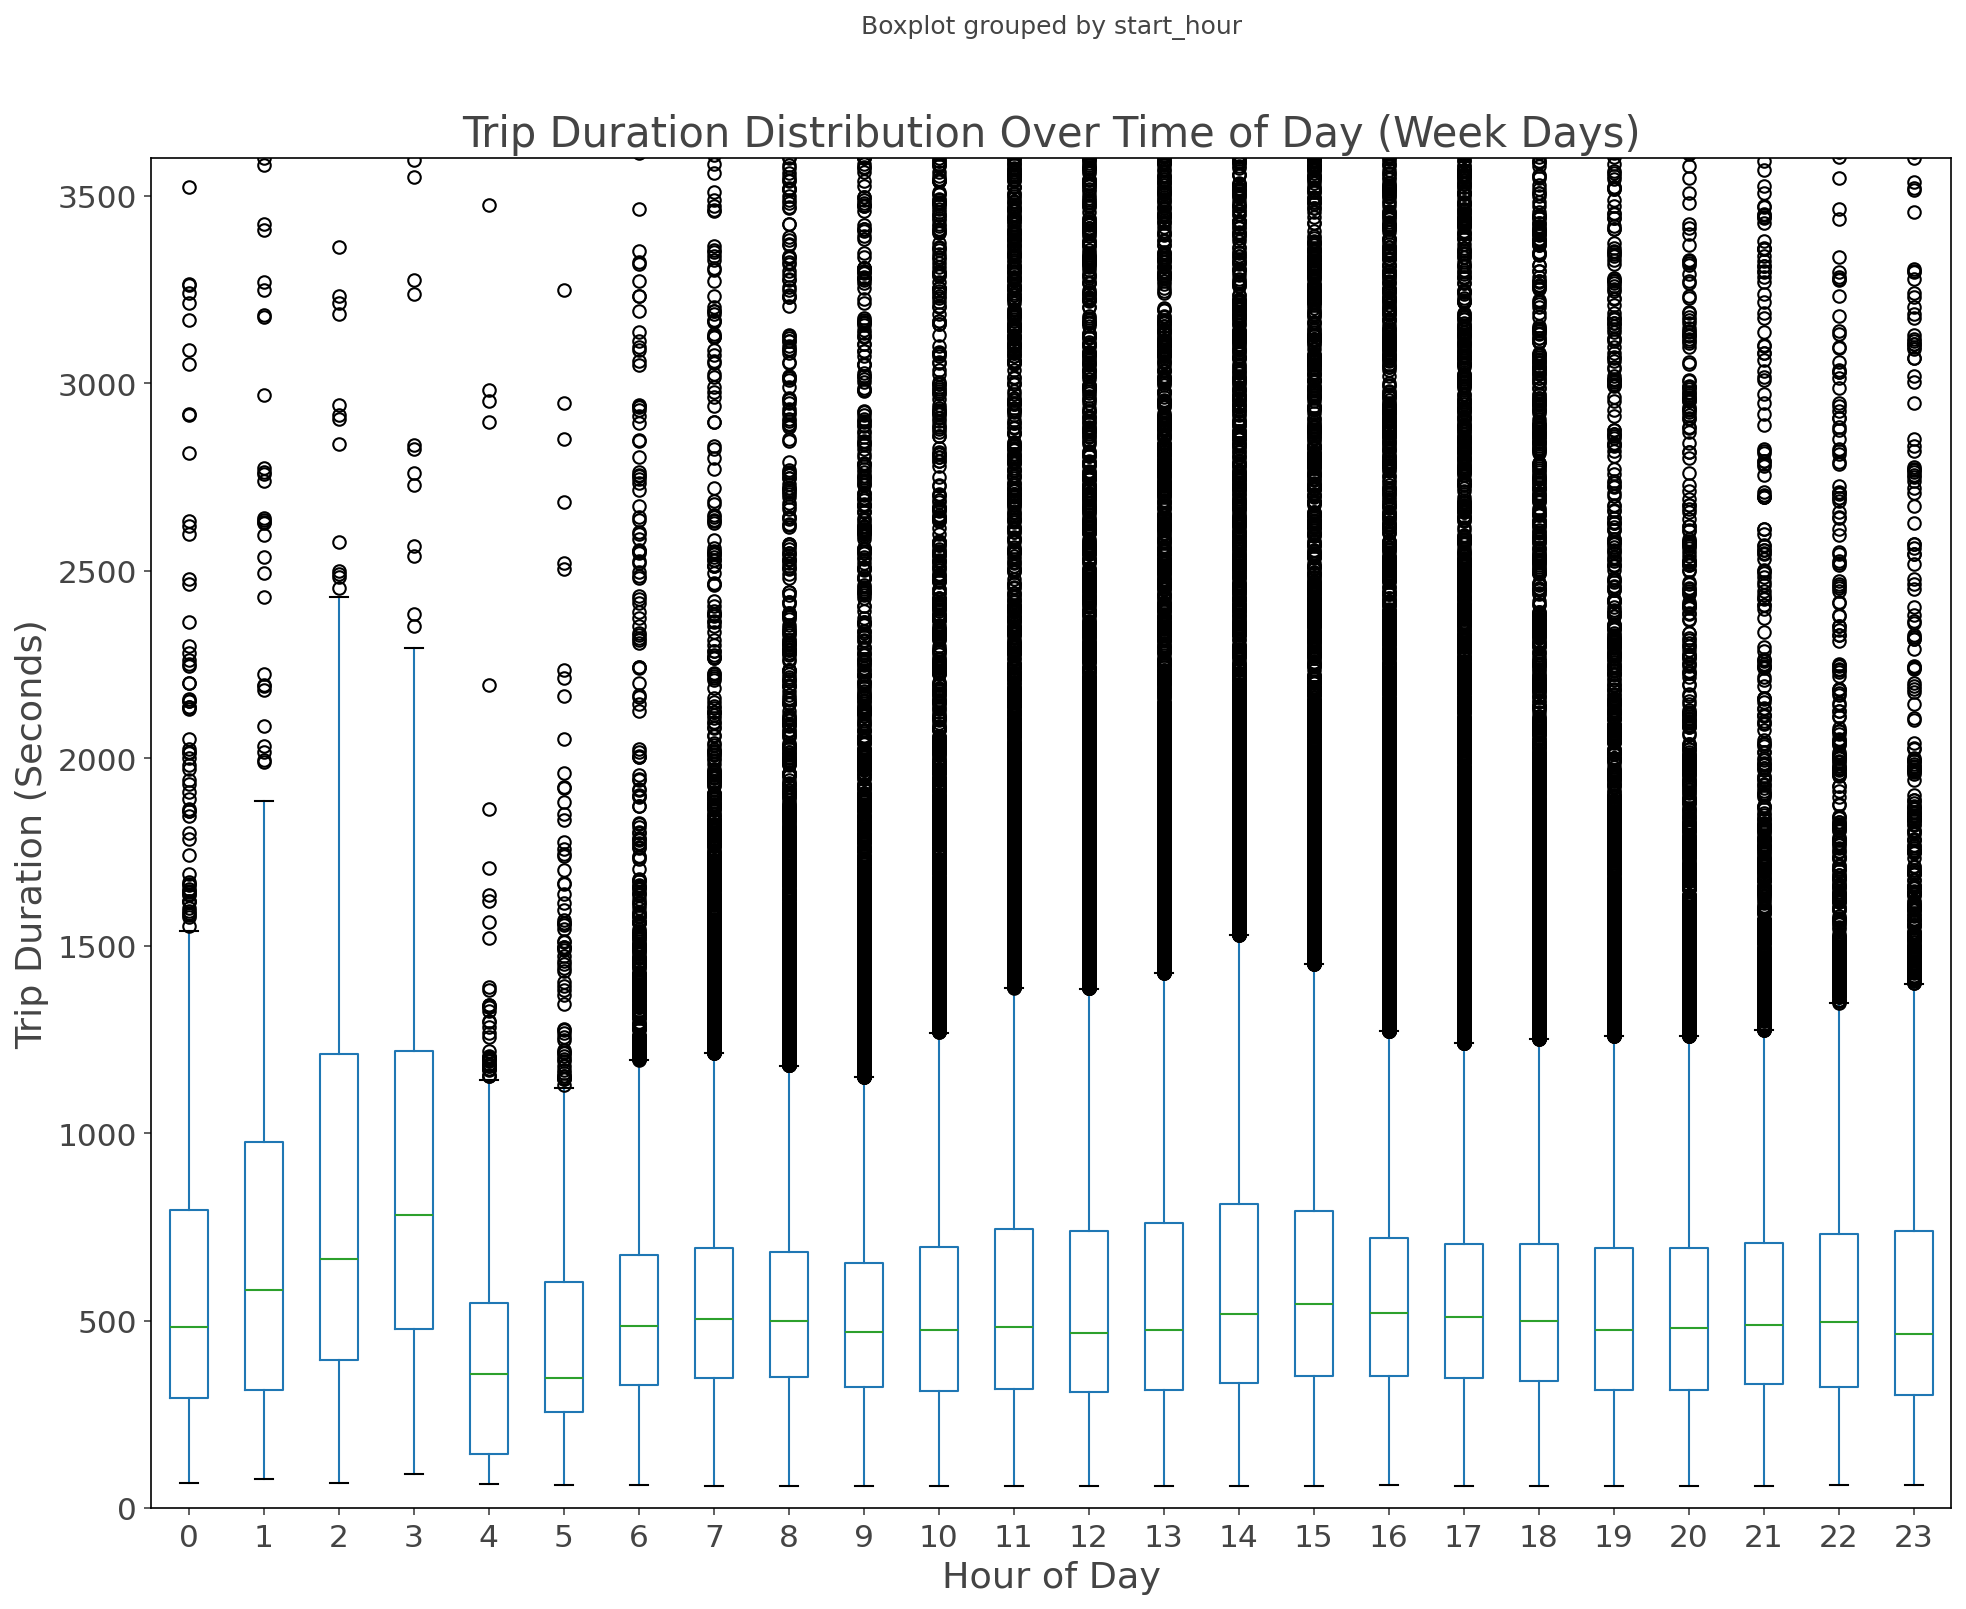

In [ ]:
plt.figure(figsize=(15,12))
weekdaytrips_df = trips_df.loc[(trips_df.duration <= 7200) & (trips_df.week <5)]
weekdaytrips_df.boxplot(column="duration",by="start_hour",figsize=(15,12))
plt.ylim(0,3600)
plt.ylabel('Trip Duration (Seconds)')
plt.xlabel('Hour of Day')
plt.title('Trip Duration Distribution Over Time of Day (Week Days)')

Text(0.5, 1.0, 'Trip Duration Distribution Over Time of Day (Weekend days)')

<Figure size 2250x1800 with 0 Axes>

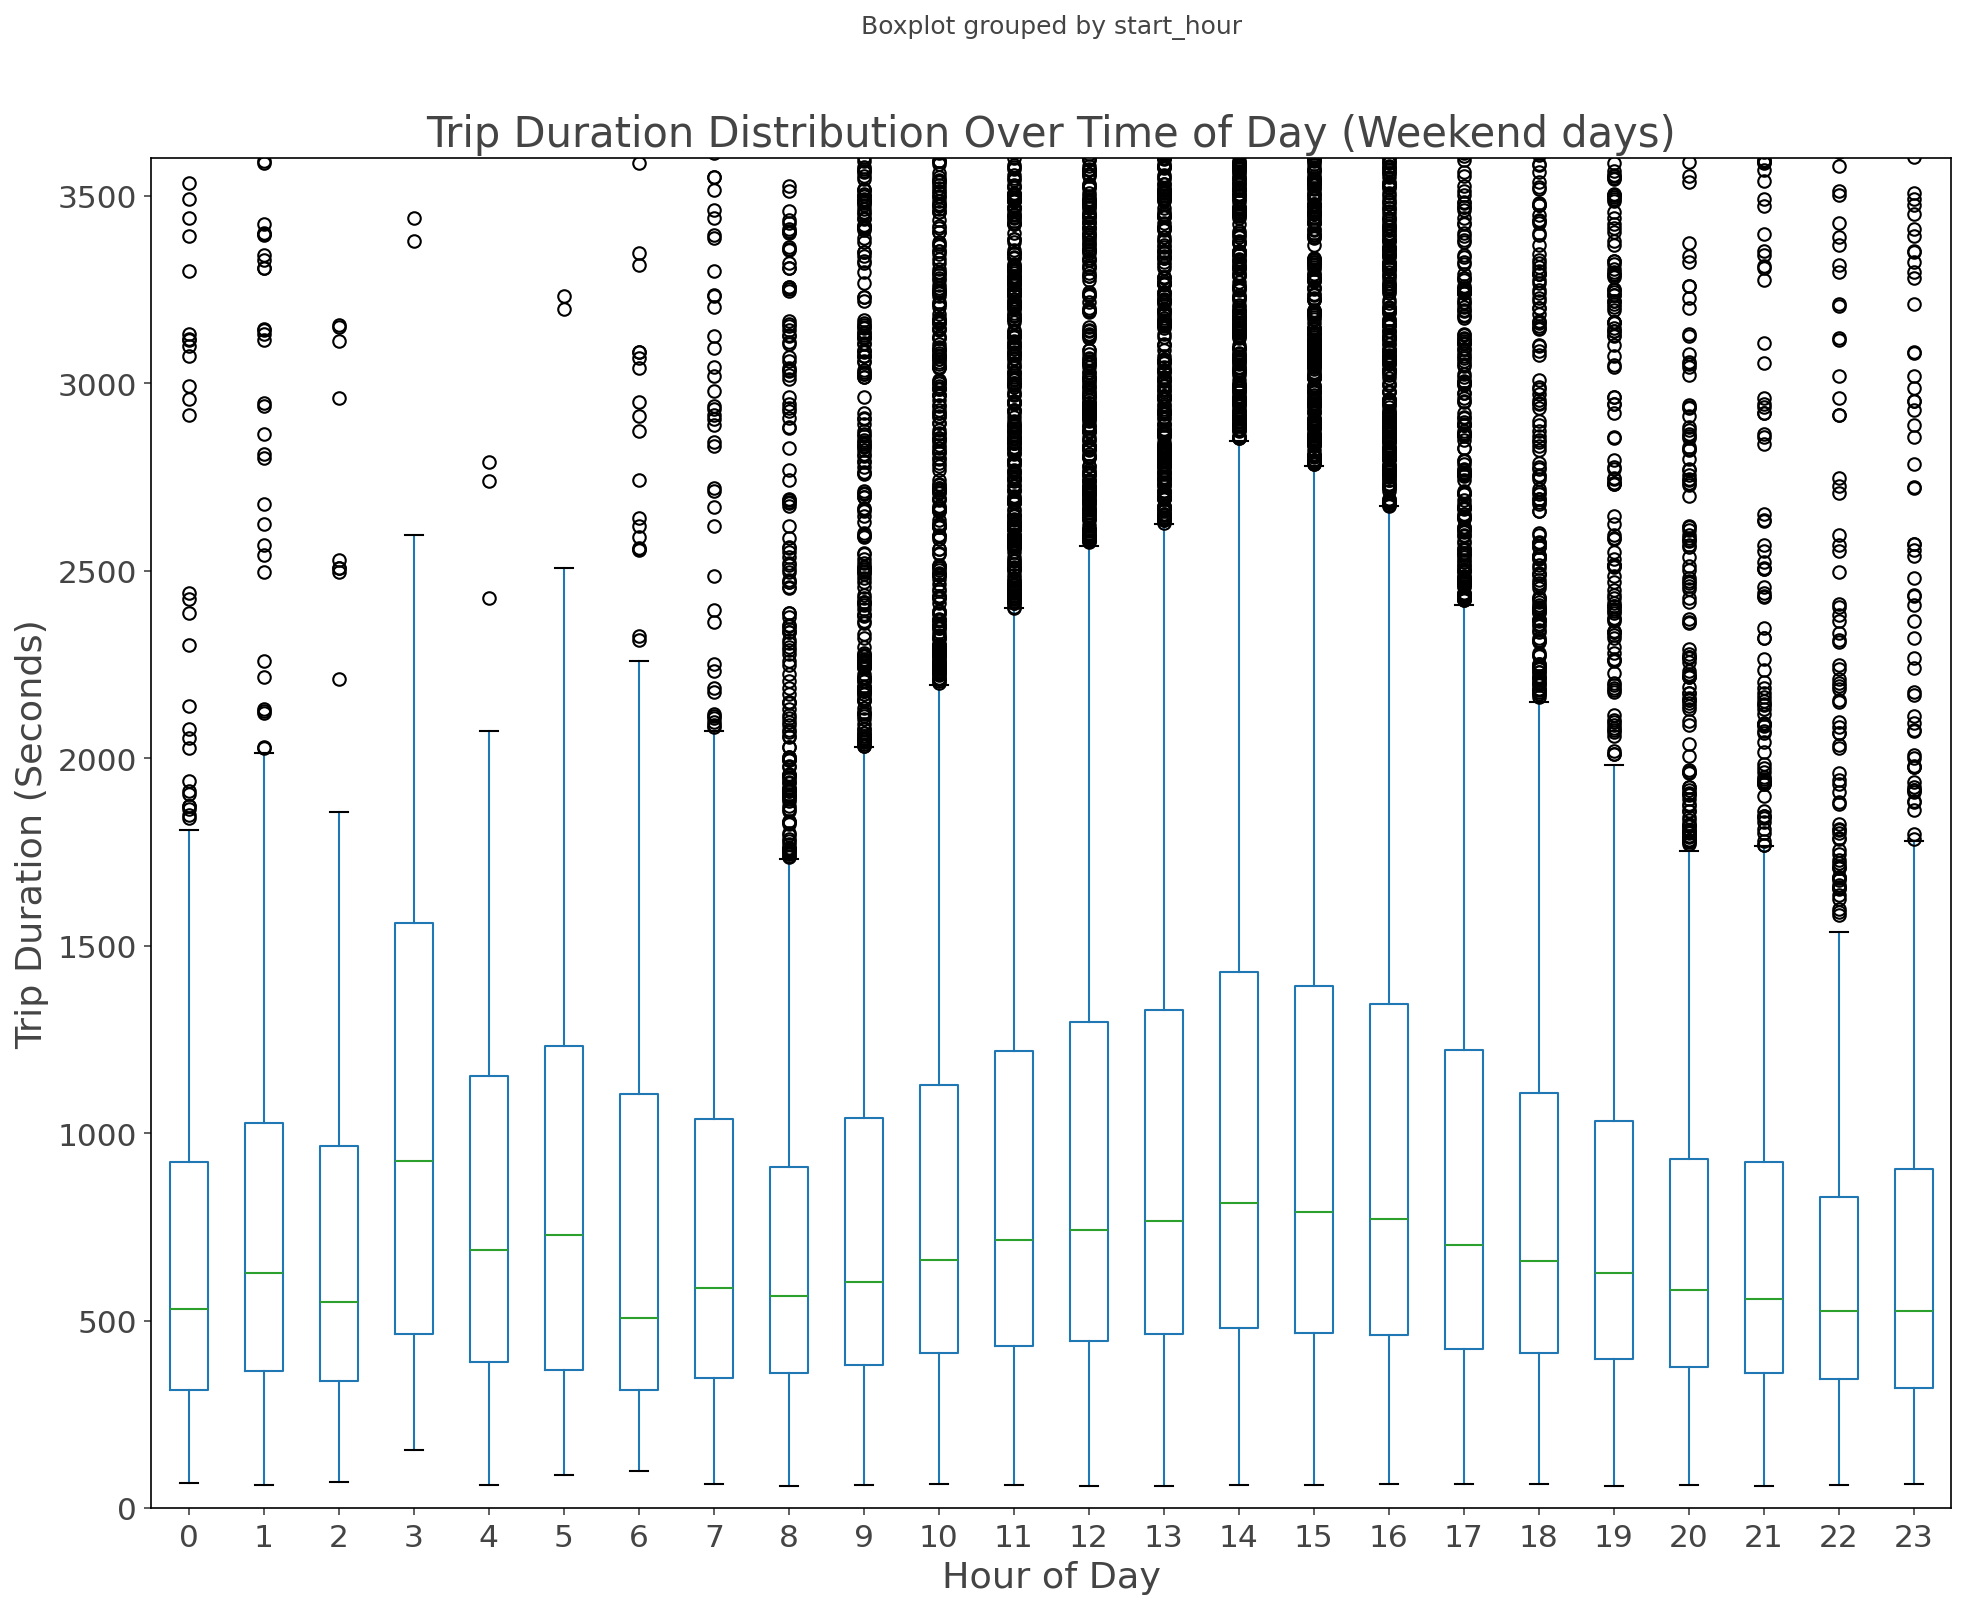

In [ ]:
plt.figure(figsize=(15,12))
weekendtrips_df = trips_df.loc[(trips_df.duration <= 7200) & (trips_df.week >4)]
weekendtrips_df.boxplot(column="duration",by="start_hour",figsize=(15,12))
plt.ylim(0,3600)
plt.ylabel('Trip Duration (Seconds)')
plt.xlabel('Hour of Day')
plt.title('Trip Duration Distribution Over Time of Day (Weekend days)')

In [ ]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
status_df = reduce_mem_usage(pd.read_csv('/content/status.csv'))

Memory usage of dataframe is 39.62 MB
Memory usage after optimization is: 13.62 MB
Decreased by 65.6%


In [ ]:
status_df.head()

,station_id,bikes_available,docks_available,time
0,2,2,25,2013/08/29 12:06:01
1,2,2,25,2013/08/29 12:07:01
2,2,2,25,2013/08/29 12:08:01
3,2,2,25,2013/08/29 12:09:01
4,2,2,25,2013/08/29 12:10:01


In [ ]:
status_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1298246 entries, 0 to 1298245
Data columns (total 4 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   station_id       1298246 non-null  int8  
 1   bikes_available  1298246 non-null  int8  
 2   docks_available  1298246 non-null  int8  
 3   time             1298246 non-null  object
dtypes: int8(3), object(1)
memory usage: 13.6+ MB


In [ ]:
status_df.time = pd.to_datetime(status_df.time, format='%Y/%m/%d %H', errors='coerce')
status_df = status_df[status_df.time.dt.minute%5 ==0]


In [ ]:
stations_df.rename(columns={"id":"station_id"},inplace=True)

In [ ]:
stations_df.installation_date = pd.to_datetime(stations_df.installation_date)

In [ ]:
status_df = status_df.merge(stations_df,on="station_id",how="left")

In [ ]:
status_df.head()

,station_id,bikes_available,docks_available,time,name,lat,long,dock_count,city,installation_date
0,6,9,6,2014-02-26,San Pedro Square,37.336721,-121.894074,15,San Jose,2013-08-07


In [ ]:
status_df.reset_index(inplace=True)
status_df.drop(columns=["index"],inplace=True)

In [ ]:
status_df["date"] = status_df.time.dt.date

In [ ]:
status_df.head()

,station_id,bikes_available,docks_available,time,name,lat,long,dock_count,city,installation_date,date
0,6,9,6,2014-02-26,San Pedro Square,37.336721,-121.894074,15,San Jose,2013-08-07,2014-02-26


In [ ]:
weather_df = reduce_mem_usage(pd.read_csv('/content/weather.csv'))

Memory usage of dataframe is 0.67 MB
Memory usage after optimization is: 0.24 MB
Decreased by 64.6%


In [ ]:
weather_df.date = pd.to_datetime(weather_df.date)

In [ ]:
weather_df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
0,2013-08-29,74.0,68.0,61.0,61.0,58.0,56.0,93.0,75.0,57.0,...,10.0,10.0,23.0,11.0,28.0,0,4.0,NaN,286.0,94107
1,2013-08-30,78.0,69.0,60.0,61.0,58.0,56.0,90.0,70.0,50.0,...,10.0,7.0,29.0,13.0,35.0,0,2.0,NaN,291.0,94107
2,2013-08-31,71.0,64.0,57.0,57.0,56.0,54.0,93.0,75.0,57.0,...,10.0,10.0,26.0,15.0,31.0,0,4.0,NaN,284.0,94107
3,2013-09-01,74.0,66.0,58.0,60.0,56.0,53.0,87.0,68.0,49.0,...,10.0,10.0,25.0,13.0,29.0,0,4.0,NaN,284.0,94107
4,2013-09-02,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,...,10.0,6.0,23.0,12.0,30.0,0,6.0,NaN,277.0,94107


In [ ]:
zipcode_city_dict = dict()
zipcode_city_dict[95113] = 'San Jose'
zipcode_city_dict[94301] = 'Palo Alto'
zipcode_city_dict[94107] = 'San Francisco'
zipcode_city_dict[94063] = 'Redwood City'
zipcode_city_dict[94041] = 'Mountain View'

In [ ]:
weather_df["city"] = weather_df.zip_code.apply(lambda x:zipcode_city_dict[x])

In [ ]:
weather_df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code,city
0,2013-08-29,74.0,68.0,61.0,61.0,58.0,56.0,93.0,75.0,57.0,...,10.0,23.0,11.0,28.0,0,4.0,NaN,286.0,94107,San Francisco
1,2013-08-30,78.0,69.0,60.0,61.0,58.0,56.0,90.0,70.0,50.0,...,7.0,29.0,13.0,35.0,0,2.0,NaN,291.0,94107,San Francisco
2,2013-08-31,71.0,64.0,57.0,57.0,56.0,54.0,93.0,75.0,57.0,...,10.0,26.0,15.0,31.0,0,4.0,NaN,284.0,94107,San Francisco
3,2013-09-01,74.0,66.0,58.0,60.0,56.0,53.0,87.0,68.0,49.0,...,10.0,25.0,13.0,29.0,0,4.0,NaN,284.0,94107,San Francisco
4,2013-09-02,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,...,6.0,23.0,12.0,30.0,0,6.0,NaN,277.0,94107,San Francisco


In [ ]:
status_df.date = pd.to_datetime(status_df.date)

In [ ]:
status_df = status_df.merge(weather_df,how="left",on=["date","city"])

In [ ]:
status_df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,station_id,bikes_available,docks_available,time,name,lat,long,dock_count,city,installation_date,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
0,6,9,6,2014-02-26,San Pedro Square,37.336721,-121.894074,15,San Jose,2013-08-07,...,9.0,3.0,29.0,13.0,40.0,0.68,7.0,Rain,129.0,95113


In [ ]:
status_df.dropna(inplace=True)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [ ]:
status_df["events"] = le.fit_transform(status_df["events"])
status_df["precipitation_inches"] = le.fit_transform(status_df["precipitation_inches"])
status_df["name"] = le.fit_transform(status_df["name"])

In [ ]:
status_df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,station_id,bikes_available,docks_available,time,name,lat,long,dock_count,city,installation_date,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
0,6,9,6,2014-02-26,0,37.336721,-121.894074,15,San Jose,2013-08-07,...,9.0,3.0,29.0,13.0,40.0,0,7.0,0,129.0,95113


In [ ]:
df = pd.DataFrame(np.random.randn(len(status_df), 1))
msk = np.random.rand(len(df)) < 0.6666
status_df_train = status_df[msk]
status_df_test = status_df[~msk]

In [ ]:
y_train = status_df_train.bikes_available
status_df_train.drop(columns=["bikes_available"],inplace=True)
y_test = status_df_test.bikes_available
status_df_test.drop(columns=["bikes_available"],inplace=True)

<ipython-input-105-86212b4396a6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  status_df_test.drop(columns=["bikes_available"],inplace=True)


In [ ]:
features = [c for c in status_df_train.columns if c not in ['time','installation_date','date','city','lat','long','name']]

In [ ]:
features

['station_id',
 'docks_available',
 'dock_count',
 'max_temperature_f',
 'mean_temperature_f',
 'min_temperature_f',
 'max_dew_point_f',
 'mean_dew_point_f',
 'min_dew_point_f',
 'max_humidity',
 'mean_humidity',
 'min_humidity',
 'max_sea_level_pressure_inches',
 'mean_sea_level_pressure_inches',
 'min_sea_level_pressure_inches',
 'max_visibility_miles',
 'mean_visibility_miles',
 'min_visibility_miles',
 'max_wind_Speed_mph',
 'mean_wind_speed_mph',
 'max_gust_speed_mph',
 'precipitation_inches',
 'cloud_cover',
 'events',
 'wind_dir_degrees',
 'zip_code']

In [ ]:
df = pd.DataFrame(np.random.randn(len(status_df), 1))
msk = np.random.rand(len(df)) < 0.6666
status_df_train = status_df[msk]
status_df_test = status_df[~msk]

In [ ]:
import time
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(status_df_train))
predictions = np.zeros(len(status_df_test))
start = time.time()
feature_importance_df = pd.DataFrame()


param = {'num_leaves': 100,
         'min_data_in_leaf': 30,
         'objective':'regression',
         'max_depth': 6,
         'learning_rate': 0.005,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1}
for fold_, (trn_idx, val_idx) in enumerate(folds.split(status_df_train.values, y_train.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(status_df_train.iloc[trn_idx][features], label=y_train.iloc[trn_idx])
    val_data = lgb.Dataset(status_df_train.iloc[val_idx][features], label=y_train.iloc[val_idx])

    num_round = 500
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof[val_idx] = clf.predict(status_df_train.iloc[val_idx][features], num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    predictions += clf.predict(status_df_test[features], num_iteration=clf.best_iteration) / folds.n_splits

ValueError: Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=1.